In [1]:
!pip install tensorflow

In [2]:
from IPython import get_ipython
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline # Magic command for Jupyter notebooks
import random
import cv2
import os
import tensorflow as tf
from tensorflow import keras # Use keras from tensorflow
from tensorflow.keras import layers, models, callbacks, backend as K # Updated imports
from tqdm.notebook import tqdm # Use tqdm.notebook for better notebook integration
import zipfile
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


In [ ]:
highres_zip_path = '/content/highres.zip'
lowres_zip_path = '/content/lowres.zip'
extract_path = '/content/'

try:
    with zipfile.ZipFile(highres_zip_path, 'r') as zip_ref:
        print(f"Extracting {highres_zip_path}...")
        zip_ref.extractall(extract_path)
    print("High resolution data extracted.")
except FileNotFoundError:
    print(f"ERROR: File not found at {highres_zip_path}. Please upload the file.")

try:
    with zipfile.ZipFile(lowres_zip_path, 'r') as zip_ref:
        print(f"Extracting {lowres_zip_path}...")
        zip_ref.extractall(extract_path)
    print("Low resolution data extracted.")
except FileNotFoundError:
    print(f"ERROR: File not found at {lowres_zip_path}. Please upload the file.")

Extracting /content/highres.zip...
High resolution data extracted.
Extracting /content/lowres.zip...
Low resolution data extracted.


In [4]:
# Modified Cell 3
# Define file paths (adjust if extraction created different folder names)
highres_folder_name = "highres/HighResolution_Train" # <-- FIXED: Point to the actual image folder
lowres_folder_name = "lowres/LowReolution_3x_Train" # <-- CHECK THIS ONE TOO! It might also need adjusting
extract_path = '/content/' # extract_path is not really needed if we specify full path fragment

# You can construct the path like this now:
good_frames_dir = os.path.join(extract_path, highres_folder_name) # Will be /content/highres/HighResolution_Train

# Or more directly:
# good_frames_dir = "/content/highres/HighResolution_Train"

# !!! IMPORTANT: Check if the low-resolution path also needs updating !!!
# Run the debug cell again but change check_dir to "/content/lowres"
# Update lowres_folder_name if needed, e.g., "lowres/LowResolution_3x_Train"
bad_frames_dir = os.path.join(extract_path, lowres_folder_name)


# Check if directories exist (updated check)
if not os.path.isdir(good_frames_dir):
    print(f"ERROR: Updated directory not found: {good_frames_dir}. Check the name 'HighResolution_Train'.")
else:
    print(f"High-res directory set to: {good_frames_dir}")

if not os.path.isdir(bad_frames_dir):
    print(f"WARNING: Low-res directory not found: {bad_frames_dir}. You might need to update 'lowres_folder_name' too.")
else:
    print(f"Low-res directory set to: {bad_frames_dir}")

High-res directory set to: /content/highres/HighResolution_Train
Low-res directory set to: /content/lowres/LowReolution_3x_Train


In [ ]:
# Load and Preprocess High-Resolution (Clean) Frames
IMG_WIDTH = 512 # Increased resolution
IMG_HEIGHT = 512 # Increased resolution
IMG_CHANNELS = 3

clean_frames = []
print(f"Loading clean frames from: {good_frames_dir}")
image_files = sorted([f for f in os.listdir(good_frames_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
print(f"Found {len(image_files)} clean images.")

for file in tqdm(image_files):
    try:
        image_path = os.path.join(good_frames_dir, file)
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255.0
        clean_frames.append(image)
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not clean_frames:
    print("ERROR: No clean frames were loaded. Check the directory path and image files.")
else:
    clean_frames = np.array(clean_frames)
    print(f"Clean frames loaded. Shape: {clean_frames.shape}")

Loading clean frames from: /content/highres/HighResolution_Train
Found 5355 clean images.


  0%|          | 0/5355 [00:00<?, ?it/s]

In [15]:
# Load and Preprocess Low-Resolution (Blurry) Frames
blurry_frames = []
print(f"Loading blurry frames from: {bad_frames_dir}")
image_files = sorted([f for f in os.listdir(bad_frames_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
print(f"Found {len(image_files)} blurry images.")

for file in tqdm(image_files):
    try:
        image_path = os.path.join(bad_frames_dir, file)
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255.0
        blurry_frames.append(image)
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not blurry_frames:
    print("ERROR: No blurry frames were loaded. Check the directory path and image files.")
else:
    blurry_frames = np.array(blurry_frames)
    print(f"Blurry frames loaded. Shape: {blurry_frames.shape}")

# Ensure the number of clean and blurry frames match
if len(clean_frames) != len(blurry_frames):
    print(f"WARNING: Mismatch in number of frames! Clean: {len(clean_frames)}, Blurry: {len(blurry_frames)}")
    # Optional: Add logic here to handle mismatch if necessary, e.g., align based on filenames.
    # For now, we proceed assuming they correspond correctly based on sorting.

Loading blurry frames from: /content/lowres/LowReolution_3x_Train
Found 5355 blurry images.


  0%|          | 0/5355 [00:00<?, ?it/s]

Blurry frames loaded. Shape: (5355, 128, 128, 3)


In [16]:
# Train/Test Split
# IMPORTANT: Use blurry frames as input (X) and clean frames as target (y)
X = blurry_frames
y = clean_frames

if len(X) == 0 or len(y) == 0:
    print("ERROR: Cannot perform train/test split because one or both datasets are empty.")
else:
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
    print("Data split into Training and Test sets:")
    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")

Data split into Training and Test sets:
x_train shape: (4819, 128, 128, 3)
y_train shape: (4819, 128, 128, 3)
x_test shape: (536, 128, 128, 3)
y_test shape: (536, 128, 128, 3)


Sample train shapes:
Input (Blurry): (128, 128, 3)
Target (Clean): (128, 128, 3)

Displaying sample index: 912


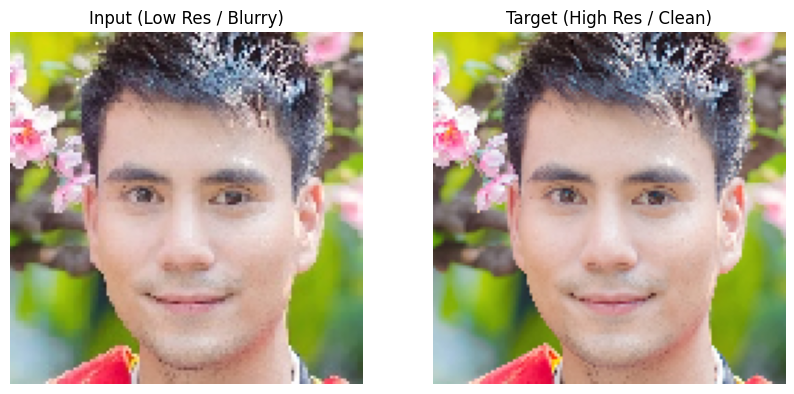

In [17]:
# Verify Shapes and Display Sample Images
if 'x_train' in locals() and len(x_train) > 0:
    print("Sample train shapes:")
    print(f"Input (Blurry): {x_train[0].shape}")
    print(f"Target (Clean): {y_train[0].shape}")

    # Display a random sample comparison
    r = random.randint(0, len(x_train) - 1)
    print(f"\nDisplaying sample index: {r}")
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(x_train[r])
    ax.set_title("Input (Low Res / Blurry)")
    ax.axis('off')

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(y_train[r])
    ax.set_title("Target (High Res / Clean)")
    ax.axis('off')

    plt.show()
else:
    print("Skipping verification - Training data not available.")

In [18]:
# Define Hyperparameters (Revisiting reduced values, adjust based on resources)
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
batch_size = 8    # Reduced batch size due to increased image size.
kernel_size = 3
latent_dim = 512 # Increased latent dimension
layer_filters = [64, 128, 256, 512] # Increased filter sizes and added a layer

In [ ]:
# Define Custom Loss and Metrics
def ssim_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    

    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr_metric(y_true, y_pred):
    # Ensure inputs are float32 and in the expected range [0, 1]
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    # Ensure inputs are float32 and in the expected range [0, 1]
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Use tf.reduce_mean to average SSIM over the batch for the metric too
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def combined_loss(y_true, y_pred, alpha=0.85): 
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mae = K.mean(K.abs(y_true - y_pred)) 
    ssim = ssim_loss(y_true, y_pred)
    return alpha * ssim + (1.0 - alpha) * mae

In [ ]:
def build_unet_autoencoder(input_shape, layer_filters, latent_dim, kernel_size):
    inputs = layers.Input(shape=input_shape, name='encoder_input')
    x = inputs
    encoder_outputs = []

    # --- Encoder Path ---
    print("Building Encoder...")
    for filters in layer_filters:
        x = layers.Conv2D(filters=filters,
            kernel_size=kernel_size,
            strides=2,
            activation='relu',
            padding="same")(x)
        

        encoder_outputs.append(x)
        print(f"    Encoder Conv block output shape: {x.shape}")

    # --- Bottleneck ---
    print("Building Bottleneck...")
    shape_before_flattening = K.int_shape(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name="latent_vector")(x)
    print(f"    Latent vector shape: {latent.shape}")

    # --- Decoder Path Start ---
    print("Building Decoder...")
    x = layers.Dense(shape_before_flattening[1] * shape_before_flattening[2] * shape_before_flattening[3],
        name='dense_decoder_start')(latent)
    x = layers.Reshape((shape_before_flattening[1], shape_before_flattening[2], shape_before_flattening[3]))(x)
    print(f"    Decoder Reshape output shape: {x.shape}")


    for filters, skip_connection in zip(layer_filters[::-1], encoder_outputs[::-1]):
        x = layers.Conv2DTranspose(filters=filters,
            kernel_size=kernel_size,
            strides=2,
            activation="relu",
            padding="same")(x)
        

        print(f"    Decoder ConvTranspose block output shape: {x.shape}")
        print(f"    Skip connection shape to concatenate: {skip_connection.shape}")

        skip_connection_cropped = layers.CenterCrop(K.int_shape(x)[1], K.int_shape(x)[2])(skip_connection)
        x = layers.Concatenate()([x, skip_connection_cropped]) # Concatenate cropped skip connection
        print(f"    Shape after concatenation: {x.shape}")

    # --- Final Output Layer ---
    outputs = layers.Conv2DTranspose(filters=input_shape[-1],
        kernel_size=kernel_size,
        padding="same",
        activation="sigmoid",
        name="decoder_output")(x)
    print(f"Final output shape: {outputs.shape}")

    # --- Define the Model ---
    autoencoder = models.Model(inputs, outputs, name="unet_autoencoder")
    return autoencoder

# Build the model
unet_model = build_unet_autoencoder(input_shape, layer_filters, latent_dim, kernel_size)
unet_model.summary()

Building Encoder...
  Encoder Conv block output shape: (None, 64, 64, 64)
  Encoder Conv block output shape: (None, 32, 32, 128)
  Encoder Conv block output shape: (None, 16, 16, 256)
Building Bottleneck...
  Latent vector shape: (None, 256)
Building Decoder...
  Decoder Reshape output shape: (None, 16, 16, 256)
  Decoder ConvTranspose block output shape: (None, 32, 32, 256)
  Skip connection shape to concatenate: (None, 16, 16, 256)
  Shape after concatenation: (None, 32, 32, 512)
  Decoder ConvTranspose block output shape: (None, 64, 64, 128)
  Skip connection shape to concatenate: (None, 32, 32, 128)
  Shape after concatenation: (None, 64, 64, 256)
  Decoder ConvTranspose block output shape: (None, 128, 128, 64)
  Skip connection shape to concatenate: (None, 64, 64, 64)
  Shape after concatenation: (None, 128, 128, 128)
Final output shape: (None, 128, 128, 3)


Model: "unet_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          1,792 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 65536)          │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_vector (Dense)     │ (None, 256)            │     16,777,472 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_decoder_start       │ (None, 65536)          │     16,842,752 │ latent_vector[0][0]    │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 16, 16, 256)    │              0 │ dense_decoder_start[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        590,080 │ reshape[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ center_crop (CenterCrop)  │ (None, 32, 32, 256)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ center_crop[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 64, 128)    │        589,952 │ concatenate[0][0]      │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ center_crop_1             │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
│ (CenterCrop)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 64, 64, 256)    │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ center_crop_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 128, 128, 64)   │        147,520 │ concatenate_1[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ center_crop_2        

 Total params: 35,322,051 (134.74 MB)

 Trainable params: 35,322,051 (134.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the Model
print("Compiling model...")
unet_model.compile(loss=combined_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[psnr_metric, ssim_metric])
print("Model compiled.")

Compiling model...
Model compiled.


In [ ]:
# Define Callbacks
print("Defining callbacks...")

# Reduce learning rate when a metric has stopped improving
lr_reducer = callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
    cooldown=0,
    patience=5,
    verbose=1,
    monitor='val_loss',
    mode='min',
    min_lr=0.5e-6)

# Save the best model based on validation SSIM
model_checkpoint = callbacks.ModelCheckpoint('best_unet_model.keras',
    monitor='val_ssim_metric',
    save_best_only=True,
    mode='max',
    verbose=1)

# Stop training if validation SSIM doesn't improve for a number of epochs
early_stopper = callbacks.EarlyStopping(monitor='val_ssim_metric',
    patience=15,
    mode='max',
    verbose=1,
    restore_best_weights=True)

callback_list = [lr_reducer, model_checkpoint, early_stopper]
print("Callbacks defined.")

Defining callbacks...
Callbacks defined.


In [ ]:
# Train the Model
EPOCHS = 100 # Start with 100, EarlyStopping will stop it if needed

print("Starting model training...")
if 'x_train' in locals():
    history = unet_model.fit(x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=EPOCHS,
        batch_size=batch_size,
        callbacks=callback_list,
        verbose=1)
    print("Model training finished.")

    best_epoch = np.argmax(history.history['val_ssim_metric'])
    print(f"\nBest validation SSIM: {history.history['val_ssim_metric'][best_epoch]:.4f} at epoch {best_epoch + 1}")
    print(f"Corresponding validation PSNR: {history.history['val_psnr_metric'][best_epoch]:.4f}")
    print(f"Corresponding validation Loss: {history.history['val_loss'][best_epoch]:.4f}")

else:
    print("Skipping training - Training data not available.")

In [ ]:
best_model_path = 'best_unet_model.keras'
if os.path.exists(best_model_path):
    print(f"Loading best model weights from: {best_model_path}")

    unet_model.load_weights(best_model_path)
    print("Best model weights loaded.")
else:
    print("WARNING: Best model file not found. Using the model state from the end of training.")

In [ ]:
# Evaluate the Model on the Test Set
print("\nEvaluating model on the entire test set...")
if 'x_test' in locals():
    # Use the evaluate method which calculates metrics based on the compilation setup
    loss, psnr, ssim = unet_model.evaluate(x_test, y_test, verbose=0)

    print(f"\nTest Evaluation Results:")
    print(f"    Test Loss (Combined): {loss:.4f}")
    print(f"    Average Test PSNR:     {psnr:.4f} dB")
    print(f"    Average Test SSIM:     {ssim:.4f}")

else:
    print("Skipping evaluation - Test data not available.")

In [ ]:
# Visualize Results: Input vs. Ground Truth vs. Prediction
print("\nVisualizing some results (Input | Ground Truth | Prediction)")
if 'x_test' in locals() and len(x_test) > 0:
    num_examples_to_show = 5
    plt.figure(figsize=(15, 4 * num_examples_to_show)) # Adjust figure size as needed

    for i in range(num_examples_to_show):
        r = random.randint(0, len(x_test) - 1)
        input_img = x_test[r]
        true_img = y_test[r]

        # Predict: requires batch dimension
        input_batch = np.expand_dims(input_img, axis=0)
        predicted_img = unet_model.predict(input_batch)[0] # Remove batch dimension from prediction

        # Calculate PSNR/SSIM for this specific image
        img_psnr = tf.image.psnr(tf.convert_to_tensor(true_img, dtype=tf.float32),
            tf.convert_to_tensor(predicted_img, dtype=tf.float32),
            max_val=1.0).numpy()
        img_ssim = tf.image.ssim(tf.convert_to_tensor(true_img, dtype=tf.float32),
            tf.convert_to_tensor(predicted_img, dtype=tf.float32),
            max_val=1.0).numpy()

        # --- Plotting ---
        # Input Image
        ax = plt.subplot(num_examples_to_show, 3, i * 3 + 1)
        ax.imshow(input_img)
        ax.set_title("Input (Low Res)")
        ax.axis('off')

        # Ground Truth Image
        ax = plt.subplot(num_examples_to_show, 3, i * 3 + 2)
        ax.imshow(true_img)
        ax.set_title("Ground Truth (High Res)")
        ax.axis('off')

        # Predicted Image
        ax = plt.subplot(num_examples_to_show, 3, i * 3 + 3)
        ax.imshow(predicted_img)
        ax.set_title(f"Prediction\nPSNR: {img_psnr:.2f} dB, SSIM: {img_ssim:.3f}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization - Test data not available.")

In [ ]:
# Plot Training History (Loss)
if 'history' in locals():
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Combined MAE+SSIM)')
    best_epoch_loss = np.argmin(history.history['val_loss'])
    plt.axvline(best_epoch_loss, color='r', linestyle='--', label=f'Best Epoch (Val Loss: {history.history["val_loss"][best_epoch_loss]:.4f})')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping loss plot - Training history not available.")

In [ ]:
if 'history' in locals():
    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot PSNR
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('PSNR (dB)', color=color)
    ax1.plot(history.history['psnr_metric'], color=color, linestyle='-', label='Train PSNR')
    ax1.plot(history.history['val_psnr_metric'], color=color, linestyle='--', label='Validation PSNR')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, axis='y')

    # Instantiate a second axes that shares the same x-axis for SSIM
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('SSIM', color=color)
    ax2.plot(history.history['ssim_metric'], color=color, linestyle='-', label='Train SSIM')
    ax2.plot(history.history['val_ssim_metric'], color=color, linestyle='--', label='Validation SSIM')
    ax2.tick_params(axis='y', labelcolor=color)

    # Highlight the best epoch based on validation SSIM
    best_epoch_ssim = np.argmax(history.history['val_ssim_metric'])
    vline = plt.axvline(best_epoch_ssim, color='g', linestyle=':', label=f'Best Epoch (Val SSIM: {history.history["val_ssim_metric"][best_epoch_ssim]:.4f})') # Assign the axvline to a variable

    # Add combined legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines.append(vline)
    labels.append(vline.get_label())

    ax2.legend(lines + lines2, labels + labels2, loc='center right')

    plt.title('Model PSNR and SSIM During Training')
    fig.tight_layout()
    plt.show()
else:
    print("Skipping metrics plot - Training history not available.")